# From Gradient descent to Adam

## Introduction

Function optimization is a central problem in applied mathematics, machine learning, and engineering. Given a real-valued function $ f : \mathbb{R}^n \to \mathbb{R} $, the goal of optimization is to find the input $ x^\star \in \mathbb{R}^n $ that minimizes the function:
$$
x^\star = \arg\min_{x \in \mathbb{R}^n} f(x).
$$

We distinguish between two types of minima:


- A point $ x^\star $ is a global minimum of $ f $ if
$$
\forall x \in \mathbb{R}^n, \quad f(x^\star) \leq f(x).
$$
- A point $ x^\star $ is a local minimum of $ f $ if there exists $ \varepsilon > 0 $ such that
$$
\forall x \in \mathbb{R}^n, \ \|x - x^\star\| < \varepsilon \Rightarrow f(x^\star) \leq f(x).
$$

In this notebook, we will explore different numerical techniques for finding minima of differentiable functions, starting with the classical gradient descent method. This method relies on the first-order derivative (gradient) of the function to iteratively move toward a local or global minimum. Visualizations will accompany each method to provide geometric intuition and illustrate convergence behavior.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [ ]:
def g(x, y):
    mux,muy,sigma = 0.3,-0.3,4
    f1 = np.exp(-((x-mux)**2+(y-muy)**2)/2.0*sigma**2)
    mux,muy,sigma = -0.3,0.3,2
    f2 = np.exp(-((x-mux)**2+(y-muy)**2)/2.0*sigma**2)
    mux,muy,sigma = 0.6,0.6,2
    f3 = np.exp(-((x-mux)**2+(y-muy)**2)/2.0*sigma**2)
    mux,muy,sigma = -0.4,-0.2,3
    f4 = np.exp(-((x-mux)**2+(y-muy)**2)/2.0*sigma**2)
    
    f = f1 + f2 - f3 - f4

    return f

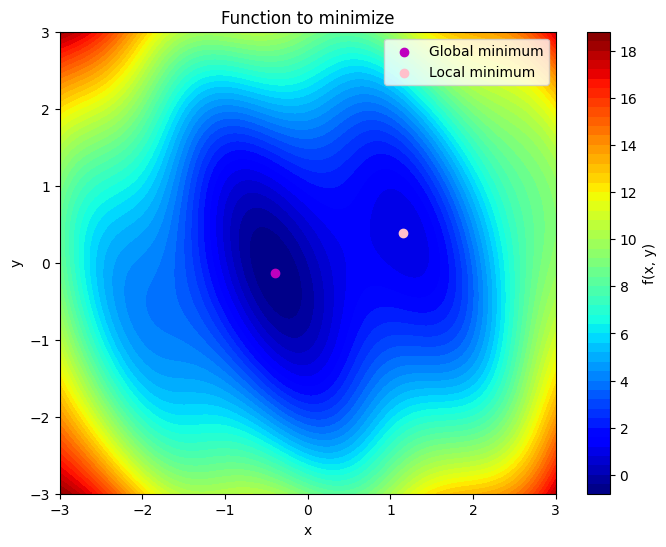

In [93]:
global_min = [-0.3919, -0.1306]
local_min = [1.1512, 0.3837]


def f(x, y):
    return x**2 + y**2 + np.sin(3*x + y)  


def grad(x, y, h=1e-5):
    df_dx = (f(x + h, y) - f(x - h, y)) / (2 * h)
    df_dy = (f(x, y + h) - f(x, y - h)) / (2 * h)
    return np.array([df_dx, df_dy])


def plot_fonction(f, history=None):
    x = np.linspace(-3, 3, 300)
    y = np.linspace(-3, 3, 300)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X, Y, Z, levels=50, cmap='jet')
    plt.colorbar(contour, label='f(x, y)')

    if history is not None:
        history = np.array(history)
        plt.plot(history[:, 0], history[:, 1], color='white', marker='o', label='Optimization path')
    
    plt.scatter(x=global_min[0], y=global_min[1], color='m', label='Global minimum')
    plt.scatter(x=local_min[0], y=local_min[1], color='pink', label='Local minimum')
    plt.title("Function to minimize")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()
        
        
plot_fonction(f)

In [90]:
import numpy as np
from scipy.optimize import minimize

def f(xy):
    x, y = xy
    return x**2 + y**2 + np.sin(3*x + y)

global_min = minimize(f, [0, 0])
print("Minimum global :", global_min.x)

bounds = [(1, 2), (0, 1)]
local_min = minimize(f, [1.5, 0.5], bounds=bounds)
print("Minimum local :", local_min.x)

Minimum global : [-0.39193201 -0.130644  ]
Minimum local : [1.15124008 0.38374823]


## Introduction to gradient descent

Gradient descent is an iterative numerical optimization method used to minimize a differentiable function $ f : \mathbb{R}^n \to \mathbb{R} $. The main idea is based on the fact that the gradient $ \nabla f(x) $ indicates the direction of greatest increase in the function. Therefore, to minimize $ f $, we move in the opposite direction to the gradient.

Starting from an initial point $ x_0 \in \mathbb{R}^n $, gradient descent generates a sequence of iterations $ (x_k)_{k \in \mathbb{N}} $ according to the following update rule:
$$
x_{k+1} = x_k - \eta \nabla f(x_k),
$$
where $ \eta > 0 $ is the learning rate, a hyperparameter controlling the size of the step taken at each iteration.

Under certain conditions (for example, if $ f $ is convex and the gradient is Lipschitz), this method converges to a stationary point of $ f $, which is a global minimum in the convex case. The performance of gradient descent depends heavily on the choice of $ \eta $; too small slows down convergence, too large can prevent convergence.

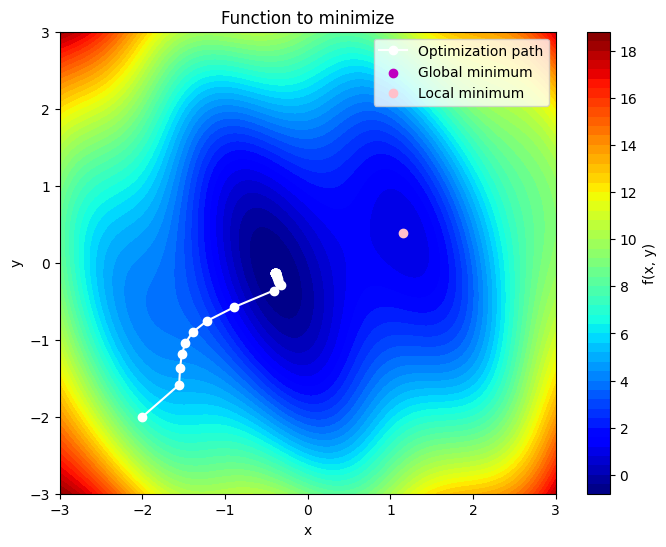

Iteration number:  33


In [ ]:

def gradient_descent(starting_point, lr=0.1, iter_max=1000):
    point = np.array(starting_point, dtype=float)
    history = [point.copy()]
    res = 1e2
    iter = 0

    while res > 1e-3 and iter < iter_max:
        gradient = grad(point[0], point[1])
        point -= lr * gradient
        
        res = np.linalg.norm(global_min - point)
        history.append(point.copy())
        iter += 1

    return history, iter



initial_point = [1.3, -2.0]
initial_point = [-2.0, -2.0]
history, n_iter = gradient_descent(initial_point)
plot_fonction(f, history)
print("Iteration number: ", n_iter)


## Gradient descent with momentum
Gradient descent with momentum (or inertia) is a variant of the classic gradient descent method, introduced to improve convergence speed and mitigate oscillations, particularly in narrow valleys or regions of high anisotropy in the function landscape. The main idea is to keep a memory of previous descent directions, accumulating a velocity that guides the current iteration.
More formally, at each iteration $ k $, a velocity vector $ v_k $ is introduced and updated according to the following rule:
$$
v_{k+1} = \mu v_k - \eta \nabla f(x_k),
$$
$$
x_{k+1} = x_k + v_{k+1},
$$
where $ \eta > 0 $ is the learning rate and $ \mu \in [0, 1 [ $ is the momentum coefficient. The term $ \mu v_k $ acts as an inertia that propagates the effects of past gradients in the current direction, accelerating convergence in consistent directions and smoothing out sudden variations due to uninformative local gradients.
Intuitively, this method works like a ball rolling down a landscape: it gains speed as it descends a slope and maintains that speed even when the slope temporarily flattens out. This allows it to move faster toward the minimum while avoiding getting trapped in small local minima or slowing down excessively on plateaus.
Descent with momentum is particularly effective in functions with directions where the curvature varies greatly (i.e., where the components of the gradient have very different magnitudes). 

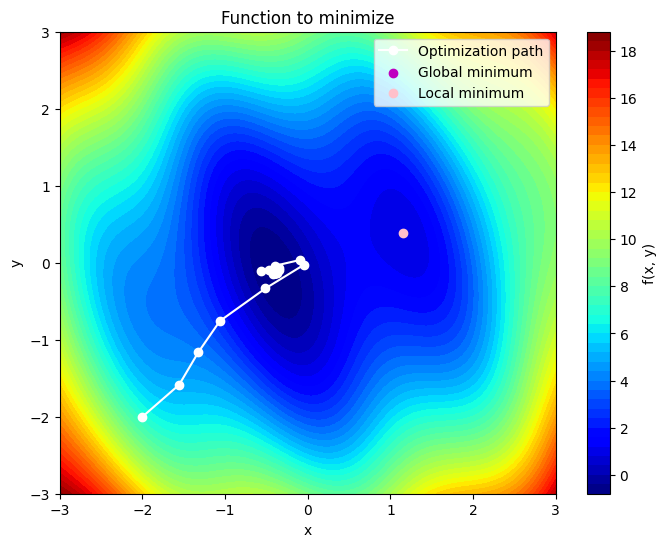

Iteration number:  21


In [136]:
def gradient_descent_momentum(starting_point, lr=0.1, beta=0.5, iter_max=1000):
    point = np.array(starting_point, dtype=float)
    velocity = np.zeros_like(point)  # terme d'inertie initialisé à 0
    history = [point.copy()]
    res = 1e2
    iter = 0

    while res > 1e-3 and iter < iter_max:
        gradient = grad(point[0], point[1])
        velocity = beta * velocity - lr * gradient
        point += velocity

        res = np.linalg.norm(global_min - point)
        history.append(point.copy())
        iter += 1

    return history, iter


initial_point = [1.3, -2.0]
initial_point = [-2.0, -2.0]
history, n_iter = gradient_descent_momentum(initial_point)
plot_fonction(f, history)
print("Iteration number: ", n_iter)

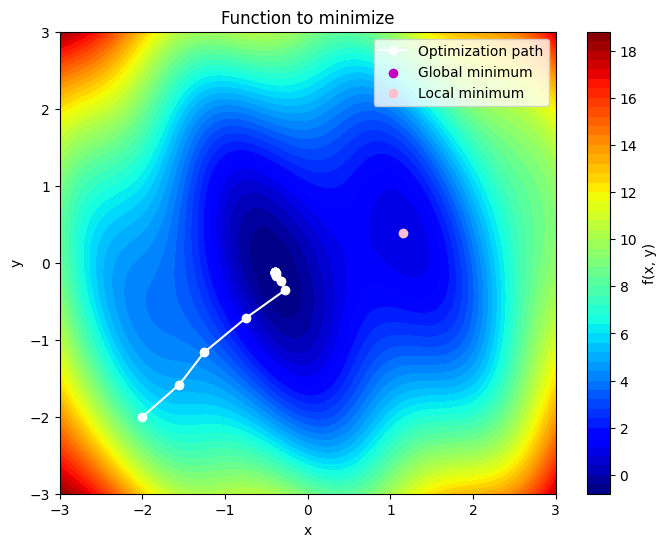

Iteration number:  16


In [165]:
def gradient_descent_nesterov(starting_point, lr=0.1, beta=0.5, iter_max=1000):
    point = np.array(starting_point, dtype=float)
    velocity = np.zeros_like(point) 
    history = [point.copy()]
    res = 10
    iter = 0

    while res > 1e-3 and iter < iter_max:
        gradient = grad(point[0] + beta * velocity[0], point[1] + beta * velocity[1])
        velocity = beta * velocity - lr * gradient
        point += velocity

        res = np.linalg.norm(global_min - point)
        history.append(point.copy())
        iter += 1

    return history, iter


initial_point = [1.3, -2.0]
initial_point = [-2.0, -2.0]
history, n_iter = gradient_descent_nesterov(initial_point)
plot_fonction(f, history)
print("Iteration number: ", n_iter)

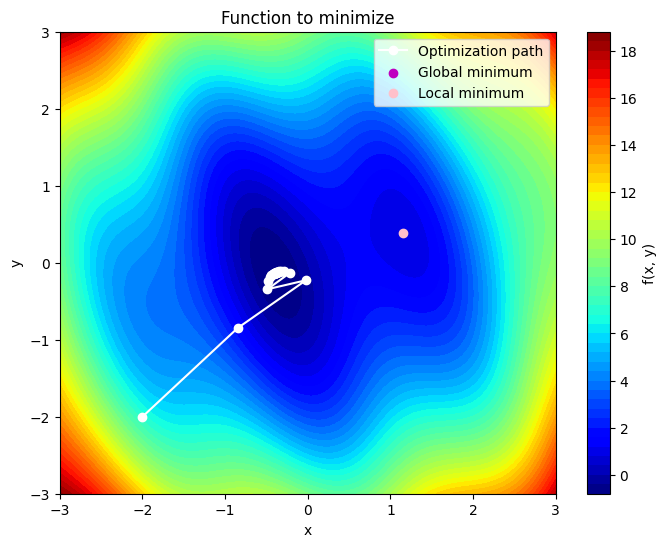

Iteration number:  31


In [ ]:
def adagrad(starting_point, lr=1.1, iter_max=1000):
    point = np.array(starting_point, dtype=float)
    history = [point.copy()]
    res = 10
    iter = 0
    epsilon = 1e-6
    velocity = np.zeros_like(point) + epsilon

    while res > 1e-3 and iter < iter_max:
        gradient = grad(point[0], point[1])
        velocity = velocity + gradient * gradient
        point -= lr * gradient / np.sqrt(velocity + epsilon)

        res = np.linalg.norm(global_min - point)
        history.append(point.copy())
        iter += 1

    return history, iter


initial_point = [1.3, -2.0]
initial_point = [-2.0, -2.0]
history, n_iter = adagrad(initial_point)
plot_fonction(f, history)
print("Iteration number: ", n_iter)

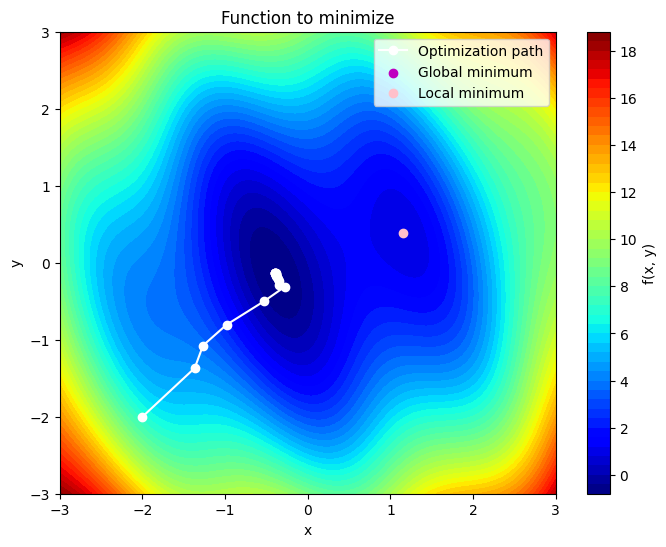

Iteration number:  18


In [161]:
def RMSProp(starting_point, lr=0.2, rho=0.9, iter_max=1000):
    point = np.array(starting_point, dtype=float)
    history = [point.copy()]
    res = 10
    iter = 0
    epsilon = 1e-6
    velocity = np.zeros_like(point) + epsilon

    while res > 1e-3 and iter < iter_max:
        gradient = grad(point[0], point[1])
        velocity = rho * velocity + (1 - rho) * gradient * gradient
        point -= lr * gradient / np.sqrt(velocity + epsilon)

        res = np.linalg.norm(global_min - point)
        history.append(point.copy())
        iter += 1

    return history, iter


initial_point = [1.3, -2.0]
initial_point = [-2.0, -2.0]
history, n_iter = RMSProp(initial_point)
plot_fonction(f, history)
print("Iteration number: ", n_iter)

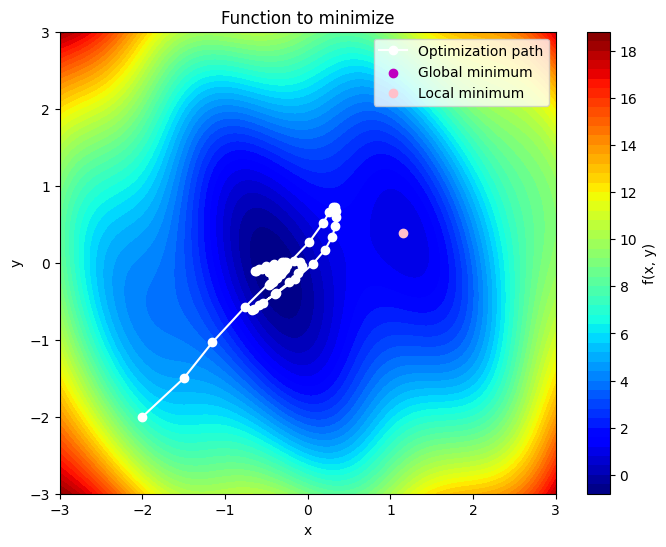

Iteration number:  110


In [171]:
def adam(starting_point, lr=0.5, beta1=0.9, beta2 = 0.999, iter_max=1000):
    point = np.array(starting_point, dtype=float)
    history = [point.copy()]
    res = 10
    iter = 1
    epsilon = 1e-6
    s = np.zeros_like(point) + epsilon
    m = np.zeros_like(point)

    while res > 1e-3 and iter < iter_max:
        gradient = grad(point[0], point[1])
        m = beta1 * m - (1 - beta1) * gradient
        s = beta2 * s + (1 - beta2) * gradient * gradient
        m_hat = m / (1 - beta1 ** iter)
        s_hat = s / (1 - beta2 ** iter)
        point += lr * m_hat / np.sqrt(s_hat + epsilon)

        res = np.linalg.norm(global_min - point)
        history.append(point.copy())
        iter += 1

    return history, iter


initial_point = [1.3, -2.0]
initial_point = [-2.0, -2.0]
history, n_iter = adam(initial_point)
plot_fonction(f, history)
print("Iteration number: ", n_iter)

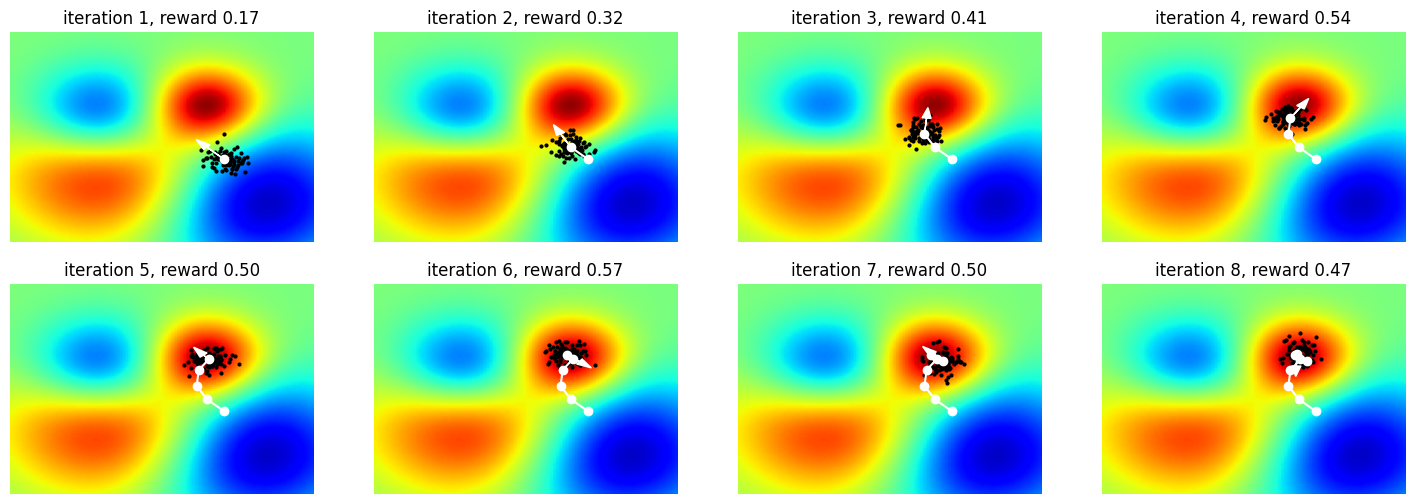

In [ ]:


n_step = 8 # number of steps to take (and plot horizontally)
alpha = 0.07 # learning rate
sigma = 3 # standard deviation of the samples around current parameter vector

w = np.array([70.0, 60.0]) # start point
plt.figure(figsize=(18,6))

prevx, prevy = [], []

for q in range(n_step):
    
    # draw the optimization landscape
    ax1 = plt.subplot(2,4,q+1)
    plt.imshow(f, vmin=-1, vmax=1, cmap='jet')

    # draw a population of samples in black
    noise = np.random.randn(100, 2)
    wp = np.expand_dims(w, 0) + sigma*noise
    x, y = zip(*wp)
    plt.scatter(x, y, 4,'k', edgecolors='face')

    # draw the current parameter vector in white
    plt.scatter([w[0]],[w[1]],40,'w', edgecolors='face')

    # draw estimated gradient as white arrow
    R = np.array([f[int(wi[1]), int(wi[0])] for wi in wp])
    R -= R.mean()
    R /= R.std() # standardize the rewards to be N(0,1) gaussian
    u = alpha * np.dot(R, noise)
    plt.arrow(w[0], w[1], u[0], u[1], head_width=3, head_length=5, fc='w', ec='w')
    
    
    # draw the history of optimization as a white line
    prevx.append(w[0])
    prevy.append(w[1])
    if len(prevx) > 0:
        plt.plot(prevx, prevy, 'wo-')
    
    w += u
    
    plt.axis('tight')
    plt.axis('off')
    plt.title('iteration %d, reward %.2f' % (q+1, f[int(w[0]), int(w[1])]))
    
plt.show()